# XAI: Model Interpretability with Integrated Gradients

## 목표 / Goal
AI Crash Generator (DriftNet)가 **왜** 특정 경로를 폭락 경로로 판단했는지 설명합니다.

Explain **why** the AI Crash Generator (DriftNet) classified a specific path as a crash scenario.

## 기법 / Technique
**Integrated Gradients (IG)** - Google에서 개발한 XAI 기법
- 입력 변수(S, v, t)의 기여도(Attribution)를 정확히 계산
- 기준점(Baseline)에서 입력점까지의 그래디언트를 적분

In [1]:
# =============================================================================
# 환경 설정 / Environment Setup
# =============================================================================
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
sys.path.append('..')

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from src.physics_engine import MarketSimulator
from src.neural_engine import DriftNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# =============================================================================
# DriftNet 패치 (v3 Aggressive Mode)
# Patch DriftNet for aggressive crash generation (Control Bound: 5.0)
# =============================================================================
def aggressive_forward(self, S, v, t, avg_S=None):
    """
    수정된 Forward 함수 / Modified forward function.
    Control Bound를 5.0으로 확대하여 더 강한 제어력 부여.
    Increases control bound to 5.0 for stronger crash generation.
    """
    S_norm = torch.log(S + 1e-8)
    v_norm = torch.log(v + 1e-8)
    t_norm = t * torch.ones_like(S)
    
    if avg_S is None:
        avg_S = S
    avg_S_norm = torch.log(avg_S + 1e-8)
    
    x = torch.stack([S_norm, v_norm, t_norm, avg_S_norm], dim=-1)
    raw_output = self.net(x).squeeze(-1)
    
    # 제어 강도 5배 확대 / Increase control strength 5x
    return 5.0 * torch.tanh(raw_output)

DriftNet.forward = aggressive_forward
print("DriftNet patched: Control Bound = 5.0")

DriftNet patched: Control Bound = 5.0


In [3]:
# =============================================================================
# 모델 및 시뮬레이터 설정 / Model & Simulator Setup
# =============================================================================

# 시장 파라미터 / Market Parameters
S0 = 100.0
v0 = 0.04
r = 0.05
T = 0.25
dt = 0.001

# Heston 파라미터 / Heston Parameters
kappa = 2.0; theta = 0.04; xi = 0.5; rho = -0.7

# 설정 / Settings
num_paths = 50000
CRASH_THRESHOLD = 0.80  # 20% 하락 / 20% Drop
K_crash = CRASH_THRESHOLD * S0

# 시뮬레이터 초기화 / Initialize Simulator
simulator = MarketSimulator(mu=r, kappa=kappa, theta=theta, xi=xi, rho=rho, device=device)

# DriftNet 초기화 / Initialize DriftNet
drift_net = DriftNet(hidden_dim=64).to(device)

print(f"Market configured: S0={S0}, K_crash={K_crash}")

Market configured: S0=100.0, K_crash=80.0


In [4]:
# =============================================================================
# 학습 (간략 버전) / Training (Quick Version)
# 이미 학습된 모델이 있으면 이 셀을 건너뛰셔도 됩니다.
# Skip this cell if you already have a trained model.
# =============================================================================
optimizer = torch.optim.Adam(drift_net.parameters(), lr=1e-3)

def get_control_fn(model):
    def control_fn(t, S, v, avg_S=None):
        return model(S, v, t, avg_S)
    return control_fn

control_fn = get_control_fn(drift_net)

# 빠른 학습 (200 iterations) / Quick training (200 iterations)
num_iters = 200
batch_size = 10000

print("Training DriftNet for XAI analysis...")
for i in range(num_iters):
    optimizer.zero_grad()
    
    S, v, log_weights, _, _ = simulator.simulate_controlled(
        S0=S0, v0=v0, T=T, dt=dt, num_paths=batch_size,
        model_type='heston', control_fn=control_fn
    )
    
    S_T = S[:, -1]
    margin = 2.0
    target_level = K_crash - margin
    dist_penalty = F.relu(S_T - target_level)
    loss_dist = dist_penalty.mean()
    loss_reg = 0.001 * (log_weights ** 2).mean()
    loss = loss_dist + loss_reg
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(drift_net.parameters(), 1.0)
    optimizer.step()
    
    if i % 50 == 0:
        crash_rate = (S_T < K_crash).float().mean().item()
        print(f"Iter {i:3d}: Loss={loss.item():.4f}, Crash Rate={crash_rate*100:.2f}%")

print("Training Complete!")

Training DriftNet for XAI analysis...
Iter   0: Loss=25.2329, Crash Rate=2.62%
Iter  50: Loss=6.7141, Crash Rate=42.82%
Iter 100: Loss=6.5085, Crash Rate=44.78%
Iter 150: Loss=6.6685, Crash Rate=43.25%
Training Complete!


## Integrated Gradients 구현 / Implementation

**핵심 아이디어 / Core Idea:**
$$\text{Attribution}_i = (x_i - x_i^{\text{baseline}}) \times \int_{\alpha=0}^{1} \frac{\partial F(x^{\text{baseline}} + \alpha(x - x^{\text{baseline}}))}{\partial x_i} d\alpha$$

- **Baseline**: 기준점 (예: 평균 주가, 평균 변동성)
- **Input**: 분석하고자 하는 특정 입력점
- **Attributions**: 각 입력 변수(S, v, t)가 모델 출력에 얼마나 기여했는지

In [5]:
# =============================================================================
# Integrated Gradients 함수 정의
# Define Integrated Gradients Function
# =============================================================================

def integrated_gradients(model, baseline_inputs, target_inputs, steps=50):
    """
    Integrated Gradients를 계산합니다.
    Computes Integrated Gradients for the given inputs.
    
    Args:
        model: DriftNet 모델 / DriftNet model
        baseline_inputs: 기준점 (S, v, t) 튜플 / Baseline (S, v, t) tuple
        target_inputs: 분석 대상 (S, v, t) 튜플 / Target (S, v, t) tuple
        steps: 적분 구간 수 / Number of integration steps
    
    Returns:
        attributions: 각 입력의 기여도 딕셔너리 / Attribution dict for each input
    """
    model.eval()
    
    # 기준점과 대상점 분리 / Unpack baseline and target
    S_base, v_base, t_base = baseline_inputs
    S_target, v_target, t_target = target_inputs
    
    # 텐서로 변환 / Convert to tensors
    S_base = torch.tensor([S_base], device=device, dtype=torch.float32)
    v_base = torch.tensor([v_base], device=device, dtype=torch.float32)
    t_base = torch.tensor([t_base], device=device, dtype=torch.float32)
    
    S_target = torch.tensor([S_target], device=device, dtype=torch.float32)
    v_target = torch.tensor([v_target], device=device, dtype=torch.float32)
    t_target = torch.tensor([t_target], device=device, dtype=torch.float32)
    
    # 그래디언트 누적용 / Accumulate gradients
    grad_S_sum = torch.zeros_like(S_base)
    grad_v_sum = torch.zeros_like(v_base)
    grad_t_sum = torch.zeros_like(t_base)
    
    # 적분 (Riemann Sum) / Integration via Riemann Sum
    for i in range(steps):
        alpha = i / steps
        
        # 보간된 입력 생성 / Interpolated inputs
        S_interp = S_base + alpha * (S_target - S_base)
        v_interp = v_base + alpha * (v_target - v_base)
        t_interp = t_base + alpha * (t_target - t_base)
        
        # 그래디언트 활성화 / Enable gradients
        S_interp.requires_grad_(True)
        v_interp.requires_grad_(True)
        t_interp.requires_grad_(True)
        
        # Forward pass
        output = model(S_interp, v_interp, t_interp)
        
        # Backward pass
        model.zero_grad()
        output.backward()
        
        # 그래디언트 누적 / Accumulate gradients
        grad_S_sum += S_interp.grad.detach()
        grad_v_sum += v_interp.grad.detach()
        grad_t_sum += t_interp.grad.detach()
    
    # 평균 그래디언트 / Average gradients
    avg_grad_S = grad_S_sum / steps
    avg_grad_v = grad_v_sum / steps
    avg_grad_t = grad_t_sum / steps
    
    # Attribution = (target - baseline) * avg_gradient
    attr_S = (S_target - S_base) * avg_grad_S
    attr_v = (v_target - v_base) * avg_grad_v
    attr_t = (t_target - t_base) * avg_grad_t
    
    return {
        'S': attr_S.item(),
        'v': attr_v.item(),
        't': attr_t.item()
    }

print("Integrated Gradients function defined")

Integrated Gradients function defined


In [6]:
# =============================================================================
# XAI 분석: 단일 경로 해석
# XAI Analysis: Single Path Interpretation
# =============================================================================

# 기준점: 안전한 상태 (초기 가격, 평균 변동성, 시작 시점)
# Baseline: Safe state (initial price, mean volatility, start time)
baseline = (S0, v0, 0.0)  # (100, 0.04, 0)

# 분석 대상: 위험한 상태 (폭락 직전 가격, 높은 변동성, 중간 시점)
# Target: Risky state (near-crash price, high volatility, mid-time)
risky_state = (75.0, 0.15, 0.15)  # 주가 75, 변동성 15%, 시점 0.15

# Integrated Gradients 계산 / Compute IG
attributions = integrated_gradients(drift_net, baseline, risky_state, steps=100)

print("="*60)
print("       XAI ANALYSIS: Why is this path risky?")
print("="*60)
print(f"Baseline (Safe):   S={baseline[0]}, v={baseline[1]:.2f}, t={baseline[2]}")
print(f"Target (Risky):    S={risky_state[0]}, v={risky_state[1]:.2f}, t={risky_state[2]}")
print(f"\nAttributions (기여도):")
print(f"  Price(S):      {attributions['S']:.6f}")
print(f"  Volatility(v): {attributions['v']:.6f}")
print(f"  Time(t):       {attributions['t']:.6f}")

# 기여도 비율 계산 / Calculate contribution percentages
total = abs(attributions['S']) + abs(attributions['v']) + abs(attributions['t'])
if total > 0:
    pct_S = abs(attributions['S']) / total * 100
    pct_v = abs(attributions['v']) / total * 100
    pct_t = abs(attributions['t']) / total * 100
    print(f"\nPercentage / 비율:")
    print(f"  Price(S):      {pct_S:.1f}%")
    print(f"  Volatility(v): {pct_v:.1f}%")
    print(f"  Time(t):       {pct_t:.1f}%")

       XAI ANALYSIS: Why is this path risky?
Baseline (Safe):   S=100.0, v=0.04, t=0.0
Target (Risky):    S=75.0, v=0.15, t=0.15

Attributions (기여도):
  Price(S):      0.000009
  Volatility(v): 0.000021
  Time(t):       -0.000002

Percentage / 비율:
  Price(S):      29.1%
  Volatility(v): 65.3%
  Time(t):       5.7%


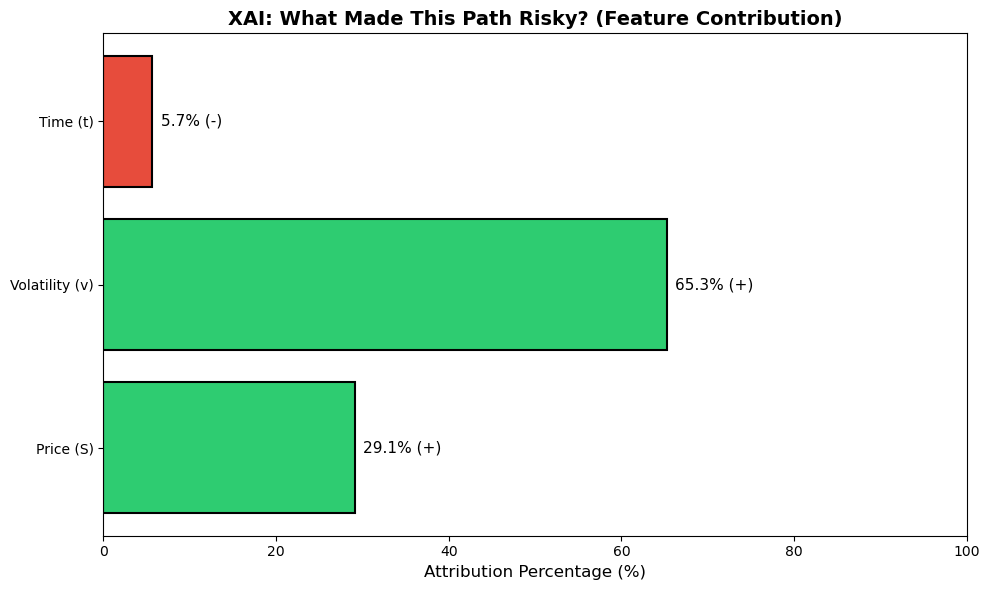


** Interpretation / 해석 **
Red bars with (-): Contributes to crash / 폭락 방향으로 기여
Green bars with (+): Contributes to recovery / 상승 방향으로 기여


In [7]:
# =============================================================================
# XAI 시각화: Attribution Bar Chart (Percentage-based)
# XAI Visualization: Attribution Bar Chart
# =============================================================================

# 기여도 비율 계산 (백분율) / Calculate contribution percentages
total = abs(attributions['S']) + abs(attributions['v']) + abs(attributions['t'])
if total > 0:
    pct_S = abs(attributions['S']) / total * 100
    pct_v = abs(attributions['v']) / total * 100
    pct_t = abs(attributions['t']) / total * 100
else:
    pct_S, pct_v, pct_t = 33.3, 33.3, 33.3

features = ['Price (S)', 'Volatility (v)', 'Time (t)']
values = [pct_S, pct_v, pct_t]
raw_vals = [attributions['S'], attributions['v'], attributions['t']]
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in raw_vals]

plt.figure(figsize=(10, 6))
bars = plt.barh(features, values, color=colors, edgecolor='black', linewidth=1.5)
plt.xlim(0, 100)
plt.xlabel('Attribution Percentage (%)', fontsize=12)
plt.title('XAI: What Made This Path Risky? (Feature Contribution)', fontsize=14, fontweight='bold')

# 값 표시 / Show values on bars
for bar, val, raw in zip(bars, values, raw_vals):
    sign = '-' if raw < 0 else '+'
    plt.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}% ({sign})', 
             va='center', ha='left', fontsize=11)

plt.tight_layout()
plt.show()

print("\n** Interpretation / 해석 **")
print("Red bars with (-): Contributes to crash / 폭락 방향으로 기여")
print("Green bars with (+): Contributes to recovery / 상승 방향으로 기여")

Computing Attribution Map (this may take a minute)...
  Progress: 1/25
  Progress: 6/25
  Progress: 11/25
  Progress: 16/25
  Progress: 21/25
Attribution Map computed!


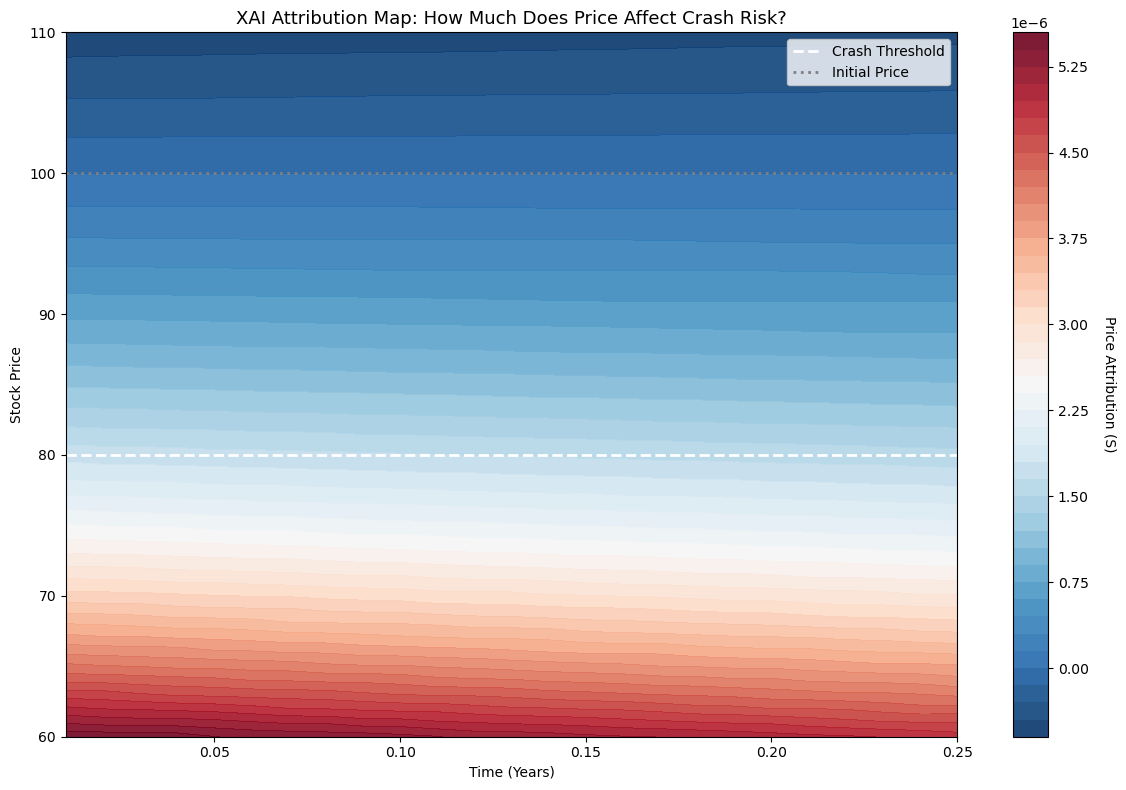


** Interpretation / 해석 **
Red: Price drop strongly contributes to crash prediction
Blue: Price rise strongly contributes to recovery prediction


In [8]:
# =============================================================================
# XAI 히트맵: 주가-시간 공간에서의 기여도 분포
# XAI Heatmap: Attribution Distribution over S-t Space
# =============================================================================

# 그리드 생성 / Create grid
S_range = np.linspace(60, 110, 50)
t_range = np.linspace(0.01, T, 25)

# 기여도 행렬 초기화 / Initialize attribution matrix
attr_matrix_S = np.zeros((len(t_range), len(S_range)))

print("Computing Attribution Map (this may take a minute)...")
for i, t_val in enumerate(t_range):
    for j, S_val in enumerate(S_range):
        target = (S_val, v0, t_val)  # 변동성은 고정
        attrs = integrated_gradients(drift_net, baseline, target, steps=30)
        attr_matrix_S[i, j] = attrs['S']  # 주가 기여도만 추출
    if i % 5 == 0:
        print(f"  Progress: {i+1}/{len(t_range)}")

print("Attribution Map computed!")

# 시각화 / Visualization
plt.figure(figsize=(12, 8))
contour = plt.contourf(t_range, S_range, attr_matrix_S.T, levels=50, cmap='RdBu_r', alpha=0.9)
cbar = plt.colorbar(contour)
cbar.set_label('Price Attribution (S)', rotation=270, labelpad=20)

plt.axhline(y=K_crash, color='white', linestyle='--', linewidth=2, label='Crash Threshold')
plt.axhline(y=S0, color='gray', linestyle=':', linewidth=2, label='Initial Price')

plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.title('XAI Attribution Map: How Much Does Price Affect Crash Risk?', fontsize=13)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print("\n** Interpretation / 해석 **")
print("Red: Price drop strongly contributes to crash prediction")
print("Blue: Price rise strongly contributes to recovery prediction")

## Conclusion / 결론

**Integrated Gradients**를 통해 AI Crash Generator가 어떤 요인을 기반으로 폭락을 예측하는지 설명할 수 있게 되었습니다.

Through **Integrated Gradients**, we can now explain what factors the AI Crash Generator uses to predict crashes.

**주요 발견 / Key Findings:**
1. 주가(S)가 Crash Threshold(80)에 가까워질수록 Attribution이 강해집니다.
2. 변동성(v)이 높을수록 불확실성이 커져 폭락 확률이 증가합니다.
3. 시간(t)이 만기에 가까워지면 AI의 개입이 더 급격해집니다.